In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

In [2]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [3]:
### READ DATA ###

df = pd.read_csv('QuoteConversion.csv.zip').drop('QuoteNumber', axis=1).sort_values('Original_Quote_Date')
df['Original_Quote_Date'] = pd.to_datetime(df.Original_Quote_Date)

print(df.shape)
df.head()

(260753, 298)


,Original_Quote_Date,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,...,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
134059,2013-01-01,0,E,8,0.9368,0.0006,"1,480",1.2714,N,14,...,7,7,-1,18,-1,7,-1,18,N,IL
15005,2013-01-01,0,B,23,0.9219,0.0006,965,1.0000,N,25,...,25,25,-1,22,-1,16,-1,17,N,CA
43051,2013-01-01,0,J,12,0.9559,0.0004,"1,165",1.2392,N,25,...,4,3,-1,10,-1,15,-1,15,N,TX
103712,2013-01-01,0,J,4,0.9559,0.0004,"1,165",1.2392,N,10,...,8,7,-1,16,-1,2,-1,21,N,TX
243189,2013-01-01,0,E,23,0.9368,0.0006,"1,480",1.2714,N,9,...,10,10,-1,23,-1,8,-1,8,N,IL


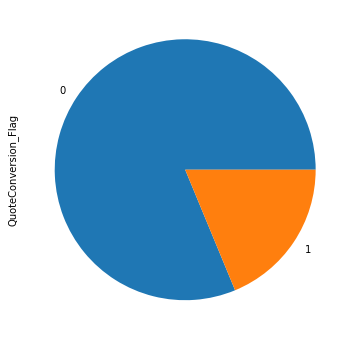

In [4]:
### LABEL DISTRIBUTION ###

df.QuoteConversion_Flag.value_counts().plot.pie(figsize=(6,6))

In [5]:
### CREATE FUNCTION FOR CATEGORICAL FEATURES ENCODING ###

def encode_cat(df):
    
    cat_col = (df.select_dtypes(include='category').columns.tolist() + 
               df.select_dtypes(include='object').columns.tolist())
    
    for f in cat_col:
        lbl = LabelEncoder()
        lbl.fit(list(df[f].values))
        df[f] = lbl.transform(list(df[f].values))
    
    return df

In [6]:
### ENCODE CATEGORICAL FEATURES AND FILL NAN VALUES ###

df = encode_cat(df)
df = df.fillna(-999)

In [7]:
### GET FEATURES NAMES ###

features = df.columns.tolist()

features.remove('QuoteConversion_Flag')
features.remove('Original_Quote_Date')

len(features)

296

In [8]:
### TEMPORAL TRAIN TEST SPLITTING ###

X_train = df[df.Original_Quote_Date <= df.Original_Quote_Date.quantile(0.7)].reset_index(drop=True)
y_train = df.QuoteConversion_Flag[df.Original_Quote_Date <= df.Original_Quote_Date.quantile(0.7)].values

X_test = df[df.Original_Quote_Date > df.Original_Quote_Date.quantile(0.9)].reset_index(drop=True)
y_test = df.QuoteConversion_Flag[df.Original_Quote_Date > df.Original_Quote_Date.quantile(0.9)].values

In [9]:
### GET TIME REFERENCE FROM TRAIN ###

Time_train = X_train['Original_Quote_Date'].values

# BENCHMARK + STRATIFIEDKFOLD

In [10]:
### INITIALIZE UTILITY OBJECT AND CROSSVALIDATION SCHEMA ###

n_splits = 5

yoof = np.zeros(len(X_train))
pred = np.zeros(len(X_test))
AUC = np.zeros(n_splits)

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=33)

In [11]:
%%time
### TRAIN MODEL ###

for fold, (in_index, oof_index) in enumerate(skf.split(X_train, y_train)):
    
    print(fold+1, 'FOLD')
    
    scaler = StandardScaler()
    pca = PCA(n_components=50, random_state=42)

    y_in, y_oof = y_train[in_index], y_train[oof_index]
    
    X_in = X_train.loc[in_index, features].copy()
    X_in = scaler.fit_transform(X_in)
    X_in = pca.fit_transform(X_in)
    X_oof = X_train.loc[oof_index, features].copy()
    X_oof = scaler.transform(X_oof)
    X_oof = pca.transform(X_oof)
    
    model = LogisticRegression(C=0.1, solver="lbfgs", max_iter=1000)
    model.fit(X_in, y_in)
    
    yoof[oof_index] = model.predict_proba(X_oof)[:,1]
    pred += model.predict_proba(
        pca.transform(
            scaler.transform(X_test[features])
        ))[:,1]

    print('AUC', roc_auc_score(y_oof, yoof[oof_index]))
    AUC[fold] = roc_auc_score(y_oof, yoof[oof_index])  

    del model; del pca; del scaler
        
pred = pred/n_splits

1 FOLD
AUC 0.83796862288581
2 FOLD
AUC 0.8351253271130243
3 FOLD
AUC 0.839458197349332
4 FOLD
AUC 0.8377466046042376
5 FOLD
AUC 0.8409666789951422
Wall time: 42 s


In [12]:
### OOF AUC ###

AUC.mean()

0.8382530861895091

In [13]:
print(roc_auc_score(y_test, pred))
print(classification_report(y_test, pred>0.5+0))

0.7730245306453186
              precision    recall  f1-score   support

           0       0.86      0.91      0.89     20879
           1       0.48      0.35      0.41      4802

    accuracy                           0.81     25681
   macro avg       0.67      0.63      0.65     25681
weighted avg       0.79      0.81      0.80     25681



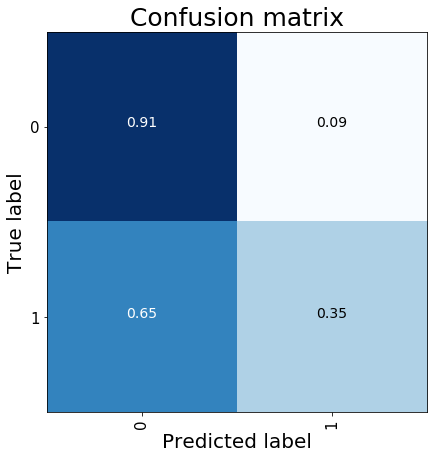

In [14]:
cnf_matrix = confusion_matrix(y_test, pred>0.5+0)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_train), title="Confusion matrix")
plt.show()

# PERMUTATION UNDERSAMPLING + KFOLD NO SHUFFLE

In [15]:
### INITIALIZE UTILITY OBJECT AND CROSSVALIDATION SCHEMA ###

n_splits = 5

seeds = range(3)
neg_istances = sum(y_train == 1)
pos_istances = sum(y_train == 0)

yoof = np.zeros((neg_istances*2, len(seeds)))
pred = np.zeros((len(X_test), len(seeds)))
AUC = np.zeros(len(seeds))

skf = KFold(n_splits=n_splits, shuffle=False)

In [16]:
%%time
### TRAIN MODEL ###

for s, seed in enumerate(seeds):
    
    train_pos = X_train.loc[y_train == 1, features].copy()
    train_pos['QuoteConversion_Flag'] = [1]*neg_istances
    train_pos['Original_Quote_Date'] = Time_train[y_train == 1]
    train_neg = X_train.loc[y_train == 0, features].copy()
    train_neg['QuoteConversion_Flag'] = [0]*pos_istances
    train_neg['Original_Quote_Date'] = Time_train[y_train == 0]
    train_neg = train_neg.sample(neg_istances, random_state=seed) #int(pos_istances*0.2)
      
    train = pd.concat([train_pos,train_neg]).sort_values('Original_Quote_Date')
    y = train.QuoteConversion_Flag.values
    train = train.drop(['Original_Quote_Date','QuoteConversion_Flag'], axis=1).reset_index(drop=True)
    
    for fold, (in_index, oof_index) in enumerate(skf.split(train, y)):
        
        print(fold+1, 'FOLD --- SEED', seed)
        
        scaler = StandardScaler()
        pca = PCA(n_components=50, random_state=seed)
        
        y_in, y_oof = y[in_index], y[oof_index]
        X_in = train.iloc[in_index, :]
        X_in = scaler.fit_transform(X_in)
        X_in = pca.fit_transform(X_in)
        X_oof = train.iloc[oof_index, :]
        X_oof = scaler.transform(X_oof)
        X_oof = pca.transform(X_oof)
        
        model = LogisticRegression(C=0.1, solver="lbfgs", max_iter=1000)
        model.fit(X_in, y_in)
        
        yoof[oof_index,s] = model.predict_proba(X_oof)[:,1]
        pred[:,s] += model.predict_proba(
                        pca.transform(
                            scaler.transform(X_test[features])
                        ))[:,1]
        
        print('AUC', roc_auc_score(y_oof, yoof[oof_index,s]))
        AUC[s] += roc_auc_score(y_oof, yoof[oof_index,s])  
        
        del model; del pca; del scaler
        
pred = pred/n_splits
AUC = AUC/n_splits

1 FOLD --- SEED 0
AUC 0.8474660156876177
2 FOLD --- SEED 0
AUC 0.8634358496165428
3 FOLD --- SEED 0
AUC 0.851811714868587
4 FOLD --- SEED 0
AUC 0.8700891850565706
5 FOLD --- SEED 0
AUC 0.85895261042491
1 FOLD --- SEED 1
AUC 0.8404916163438287
2 FOLD --- SEED 1
AUC 0.8563731372984171
3 FOLD --- SEED 1
AUC 0.8498254570816278
4 FOLD --- SEED 1
AUC 0.8606583194550836
5 FOLD --- SEED 1
AUC 0.8501963517002146
1 FOLD --- SEED 2
AUC 0.8333140112278692
2 FOLD --- SEED 2
AUC 0.8614063437444183
3 FOLD --- SEED 2
AUC 0.843633097508726
4 FOLD --- SEED 2
AUC 0.8579794349941625
5 FOLD --- SEED 2
AUC 0.849187893340843
Wall time: 46.9 s


In [17]:
### OOF AUC ###

AUC.mean()

0.8529880692232945

In [18]:
print(roc_auc_score(y_test, pred.mean(axis=1)))
print(classification_report(y_test, pred.mean(axis=1)>0.5+0))

0.8181126595658501
              precision    recall  f1-score   support

           0       0.94      0.65      0.77     20879
           1       0.35      0.83      0.49      4802

    accuracy                           0.68     25681
   macro avg       0.65      0.74      0.63     25681
weighted avg       0.83      0.68      0.72     25681



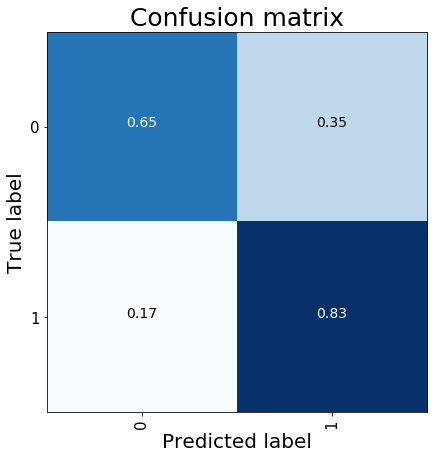

In [19]:
cnf_matrix = confusion_matrix(y_test, pred.mean(axis=1)>0.5+0)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_train), title="Confusion matrix")
plt.show()